# Session 6: Autoregressive Music Generation (Part 1)

Agenda
- Overview of the Transformer model
- Understanding Anticipatory Music Transformers
- Hands On: Using AMT to generate MIDI data

## The Transformer architecture

From the paper [Attention Is All You Need (Vaswani et al., 2017)](https://arxiv.org/abs/1706.03762).

![](./assets/transformer.png)

## Understanding Anticipatory Music Transformers

From the papers [Music Transformer (Huang et al., 2018)](https://arxiv.org/abs/1809.04281) and [Anticipatory Music Transformers (Thickstun et al., 2023)](https://arxiv.org/abs/2306.08620).

![](./assets/music_transformer.png)

## Understanding MusicGen

From the paper [Simple and Controllable Music Generation (Copet et al., 2023)](https://arxiv.org/abs/2306.05284).

![](./assets/musicgen.png)

## Hands On: Using AMT to generate MIDI Data

In [ ]:
# Clone the anticipation repository
!git clone https://github.com/lancelotblanchard/anticipation.git ../repositories/anticipation

In [27]:
import os
os.environ["HF_HUB_CACHE"] = os.path.abspath("../huggingface_hub_cache/")

from transformers import GPT2LMHeadModel

# set Hub Cache folder
model = GPT2LMHeadModel.from_pretrained("stanford-crfm/music-small-800k", attn_implementation="eager")

In [4]:
# Add our repository to the Python path

import sys
sys.path.append('../repositories/anticipation')

In [117]:
from anticipation import ops
from anticipation.config import MAX_INSTR, MAX_PITCH
from anticipation.vocab import ANTICIPATE, CONTROL_OFFSET, DUR_OFFSET, NOTE_OFFSET, TIME_OFFSET
from anticipation.sample import nucleus
import torch

# Let's look at generating some tokens unconditionally. Before we can do so,
# we need to look at building an inference function:

def generate_note(model, tokens, current_time, active_instruments, top_p=0.98, history_length=340, monophony=False):
    assert len(tokens) % 3 == 0 # we need to have a valid sequence

    history = tokens.copy()
    lookback = max(len(tokens) - 3*history_length, 0)
    history = history[lookback:]
    offset = ops.min_time(history, seconds=False)
    history[::3] = [tok - offset for tok in history[::3]] # Relative time

    new_tokens = []
    with torch.no_grad():
        for i in range(3):
            # Create the input sequence
            input_sequence = torch.tensor([ANTICIPATE] + history + new_tokens).unsqueeze(0).to(model.device)
            logits = model(input_sequence).logits[0, -1]

            # Filter the logits.
            # 1. Do not generate controls
            logits[CONTROL_OFFSET:] = -float('inf')

            # 2. For times, generate correct times that are not in the past
            if i == 0:
                logits[DUR_OFFSET:CONTROL_OFFSET] = -float('inf')
                if current_time > 0:
                    logits[TIME_OFFSET:TIME_OFFSET+current_time+(1 if monophony else 0)] = -float('inf')


            # 3. Generate correct durations
            elif i == 1:
                logits[TIME_OFFSET:DUR_OFFSET] = -float('inf')
                logits[NOTE_OFFSET:CONTROL_OFFSET] = -float('inf')

            # 4. Generate correct notes, and only generate instruments that are active
            elif i == 2:
                logits[TIME_OFFSET:NOTE_OFFSET] = -float('inf')
                active_instruments = sorted(active_instruments)
                # Filter up to lowest note of first active instrument
                logits[NOTE_OFFSET:NOTE_OFFSET + active_instruments[0]*MAX_PITCH] = -float('inf')
                # Filter between active instruments
                for j in range(len(active_instruments) - 1):
                    logits[NOTE_OFFSET + (active_instruments[j]+1)*MAX_PITCH:NOTE_OFFSET + active_instruments[j+1]*MAX_PITCH] = -float('inf')
                # Filter after highest note of last active instrument
                logits[NOTE_OFFSET + (active_instruments[-1]+1)*MAX_PITCH:] = -float('inf')

            # Sample from the logits (with Nucleus sampling)
            logits = nucleus(logits, top_p=top_p)
            probs = torch.nn.functional.softmax(logits, dim=-1)
            new_token = torch.multinomial(probs, 1).item()
            new_tokens.append(new_token)
        
    new_tokens[0] += offset # Revert back to regular time

    return new_tokens

In [38]:
# Let's try to generate a few notes

tokens = []
current_time = 0
for i in range(40):
    new_tokens = generate_note(model, tokens, current_time, active_instruments=[1])
    print(new_tokens)
    tokens += new_tokens
    current_time = new_tokens[0]

[0, 10010, 11197]
[0, 10010, 11200]
[0, 10013, 11200]
[0, 10014, 11209]
[26, 10014, 11199]
[26, 10012, 11202]
[26, 10014, 11199]
[26, 10015, 11207]
[51, 10011, 11200]
[51, 10011, 11204]
[51, 10012, 11200]
[51, 10013, 11204]
[51, 10015, 11195]
[51, 10014, 11204]
[101, 10010, 11200]
[101, 10011, 11204]
[101, 10011, 11200]
[101, 10014, 11195]
[101, 10013, 11204]
[152, 10012, 11202]
[152, 10013, 11205]
[152, 10014, 11202]
[152, 10015, 11197]
[152, 10015, 11205]
[203, 10012, 11202]
[203, 10015, 11205]
[203, 10015, 11202]
[203, 10015, 11197]
[203, 10016, 11205]
[255, 10014, 11202]
[255, 10014, 11205]
[255, 10013, 11202]
[255, 10014, 11197]
[255, 10014, 11205]
[307, 10019, 11202]
[307, 10021, 11205]
[307, 10024, 11202]
[307, 10024, 11197]
[307, 10026, 11205]
[332, 10010, 11195]


In [39]:
from anticipation.convert import events_to_midi
import midi2audio
import librosa
from IPython.display import Audio

# Let's listen to our sequence of tokens

# We first need to convert our tokens to a MIDI file
events_to_midi(tokens).save("assets/generation.mid")

midi2audio_obj = midi2audio.FluidSynth("../session2_setup/assets/soundfont.sf2")
midi2audio_obj.midi_to_audio("assets/generation.mid", "assets/generation.wav")

y, sr = librosa.load("assets/generation.wav", sr=44100)

display(Audio(y, rate=sr))

FluidSynth runtime version 2.3.5
Copyright (C) 2000-2024 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'assets/generation.wav'..


fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: panic: An error occurred while reading from stdin.


torch.Size([55028])


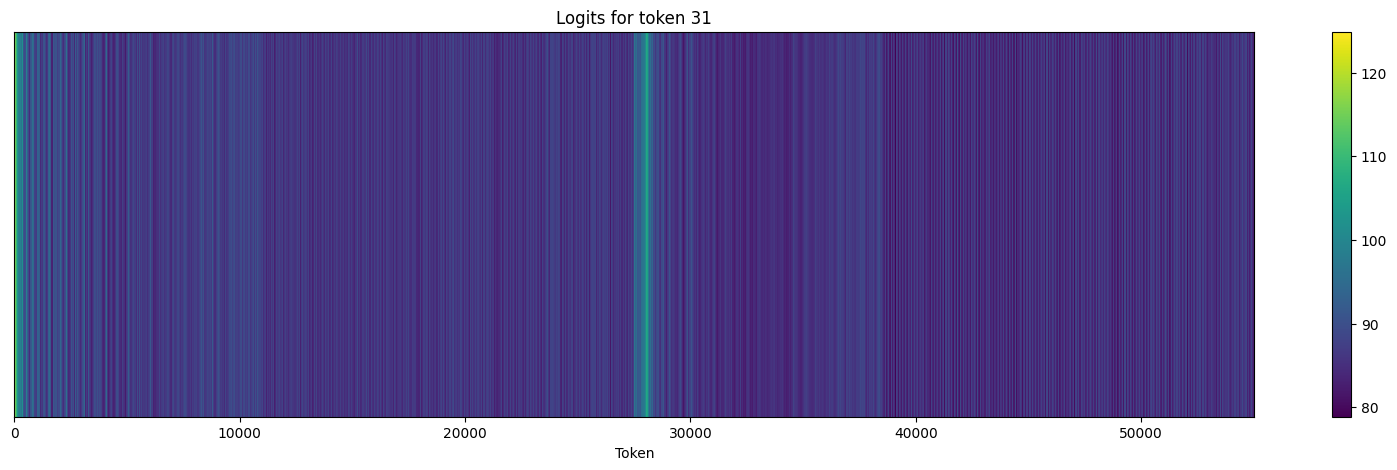

In [83]:
import matplotlib.pyplot as plt

# Let's take a look at what logits look like
tokens_subset = tokens[:3*10]
with torch.no_grad():
    input_sequence = torch.tensor([ANTICIPATE] + tokens_subset).unsqueeze(0).to(model.device)
    logits = model(input_sequence).logits[0, -1]

print(logits.shape)

plt.figure(figsize=(20, 5))
plt.imshow(logits.cpu().unsqueeze(0).numpy(), aspect='auto', interpolation='nearest')
plt.xlabel("Token")
plt.yticks([])
plt.title("Logits for token 31")
plt.colorbar()
plt.show()

Last time of the sequence is 51
New token would be sampled for 51


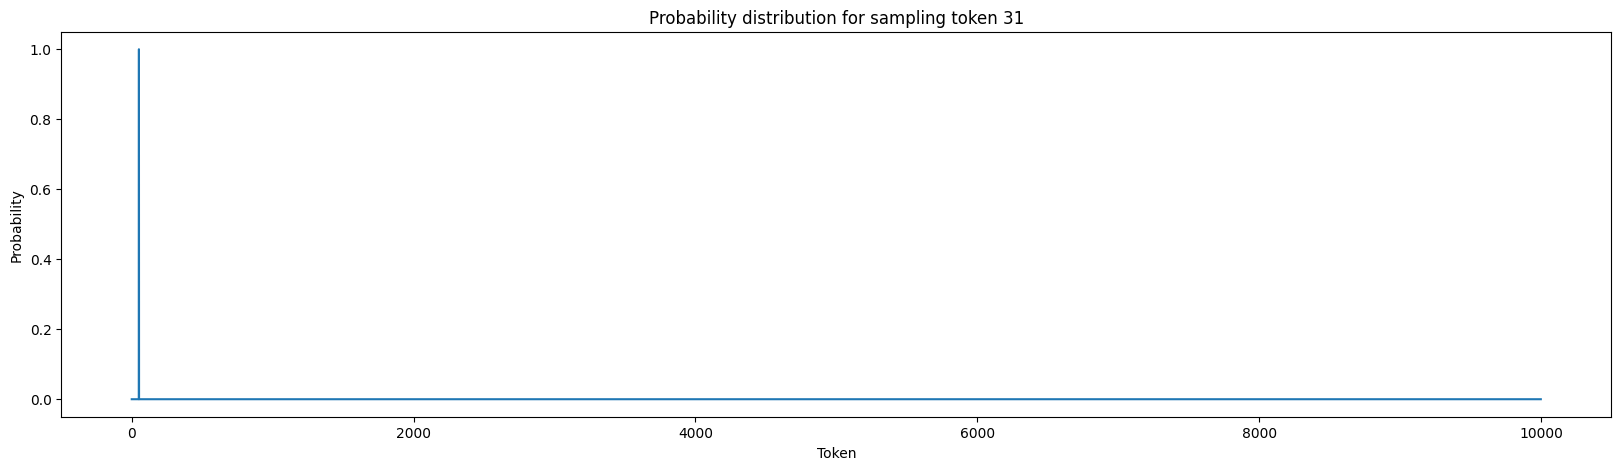

In [88]:
from anticipation.config import MAX_TIME

# Let's do the same thing after nucleus sampling processing

print(f"Last time of the sequence is {tokens_subset[-3]}")

# Safety filtering for time tokens
logits[DUR_OFFSET:] = -float('inf')
logits[TIME_OFFSET:TIME_OFFSET+tokens_subset[-3]] = -float('inf')

# Get the probability distribution of the new token
nucleus_logits = nucleus(logits, top_p=0.98)
probs = torch.nn.functional.softmax(nucleus_logits, dim=-1)
new_token = torch.multinomial(probs, 1).item()

print(f"New token would be sampled for {new_token}")

plt.figure(figsize=(20, 5))
plt.plot(probs[:MAX_TIME].cpu().numpy())
plt.xlabel("Token")
plt.title("Probability distribution for sampling token 31")
plt.ylabel("Probability")

plt.show()

In [94]:
from anticipation.convert import midi_to_events

# Let's now work with a conditioning signal! We'll convert our MIDI file to tokens

symphony40 = midi_to_events("../session2_setup/assets/symphony40.mid")
print(f"Number of tokens: {len(symphony40)}, number of notes: {len(symphony40)//3}")
print(f"First tokens: {symphony40[:6]}")

Number of tokens: 38085, number of notes: 12695
First tokens: [126, 10016, 16175, 126, 10016, 16178]


In [95]:
# We can calculate the number of instruments by looking at the tokens

instruments = set()
for note in symphony40[2::3]:
    instruments.add((note - NOTE_OFFSET) // MAX_PITCH)

print(f"Number of instruments: {len(instruments)}")
print(f"Instruments: {instruments}")

Number of instruments: 4
Instruments: {40, 73, 42, 60}


In [110]:
# Let's filter the first 238 notes of the sequence and only keep instrument 42
# We will also keep the notes of instrument 40 as a ground truth

control_tokens = []
ground_truth = []
for t, d, n in zip(symphony40[:238*3:3], symphony40[1:238*3:3], symphony40[2:238*3:3]):
    if (n - NOTE_OFFSET) // MAX_PITCH == 42:
        control_tokens += [t, d, n]
        ground_truth += [t, d, n]
    if (n - NOTE_OFFSET) // MAX_PITCH == 40:
        ground_truth += [t, d, n]

events_to_midi(control_tokens).save("assets/control.mid")
midi2audio_obj.midi_to_audio("assets/control.mid", "assets/control.wav")

y, sr = librosa.load("assets/control.wav", sr=44100)

display(Audio(y, rate=sr))

FluidSynth runtime version 2.3.5
Copyright (C) 2000-2024 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'assets/control.wav'..


fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: panic: An error occurred while reading from stdin.


In [118]:
from anticipation.config import DELTA
import math

# We will use this sequence as a conditioning signal for our generation
# Let's generate instrument 42 with the given control signal

# First, let's add CONTROL_OFFSET to the control tokens
anticipated_control_tokens = [CONTROL_OFFSET + t for t in control_tokens]

# We select the first control token and leave the rest for later
atime, adur, anote = anticipated_control_tokens[0:3]
atokens = anticipated_control_tokens[3:]
# This is the time of the first control
anticipated_time = atime - CONTROL_OFFSET

# We will generate until end time
end_time = max(control_tokens[::3])
current_time = 0
conditioned_tokens = []

# Generation loop
while current_time < end_time:
    # Anticipated if needed
    while current_time >= anticipated_time - DELTA:
        conditioned_tokens.extend([atime, adur, anote])

        if len(atokens) > 0:
            atime, adur, anote = atokens[0:3]
            atokens = atokens[3:]
            anticipated_time = atime - CONTROL_OFFSET
        else:
            anticipated_time = math.inf

    new_tokens = generate_note(model, conditioned_tokens, current_time, active_instruments=[40], monophony=True)
    print(new_tokens)
    conditioned_tokens += new_tokens
    current_time = new_tokens[0]

# We remove the control tokens and add them without CONTROL_OFFSET
conditioned_tokens, _ = ops.split(conditioned_tokens)
conditioned_tokens = ops.sort(conditioned_tokens + control_tokens)

[0, 10025, 16186]
[0, 10026, 16182]
[12, 10013, 16191]
[25, 10025, 16187]
[37, 10013, 16196]
[50, 10013, 16194]
[62, 10012, 16192]
[75, 10012, 16191]
[87, 10012, 16192]
[100, 10012, 16194]
[112, 10012, 16191]
[125, 10012, 16187]
[150, 10026, 16201]
[151, 10025, 16192]
[175, 10026, 16199]
[176, 10025, 16191]
[200, 10025, 16198]
[201, 10025, 16189]
[225, 10013, 16199]
[226, 10052, 16191]
[237, 10013, 16203]
[250, 10013, 16206]
[273, 10030, 16206]
[302, 10024, 16206]
[324, 10025, 16206]
[350, 10027, 16199]
[351, 10025, 16191]
[375, 10027, 16198]
[400, 10027, 16196]
[426, 10052, 16194]
[450, 10013, 16198]
[463, 10013, 16201]
[475, 10050, 16206]
[502, 10026, 16192]
[527, 10052, 16191]
[552, 10013, 16194]
[565, 10013, 16199]
[577, 10051, 16203]
[603, 10026, 16189]
[628, 10053, 16187]
[650, 10014, 16191]
[664, 10015, 16194]
[679, 10052, 16199]
[706, 10026, 16182]
[731, 10053, 16180]
[756, 10014, 16192]
[1028, 10030, 16201]
[1054, 10027, 16189]
[1079, 10027, 16192]
[1106, 10024, 16198]
[1130, 

In [119]:
# We can now listen to our result

events_to_midi(conditioned_tokens).save("assets/conditioned_generation.mid")

midi2audio_obj = midi2audio.FluidSynth("../session2_setup/assets/soundfont.sf2")
midi2audio_obj.midi_to_audio("assets/conditioned_generation.mid", "assets/conditioned_generation.wav")

y, sr = librosa.load("assets/conditioned_generation.wav", sr=44100)

display(Audio(y, rate=sr))

FluidSynth runtime version 2.3.5
Copyright (C) 2000-2024 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'assets/conditioned_generation.wav'..


fluidsynth: panic: An error occurred while reading from stdin.
fluidsynth: panic: An error occurred while reading from stdin.
